<text style="color:green;font-size: 250%">Попытка ID	5769352</text><br>
<text style="color:green;font-size: 120%">Решение параллельным ансамблем из Catboost и LightGBM</text>

## Описание полей

В датасете собраны данные о пользователях телекоммуникационной компании:

*   State - штат
*   Account length - как долго этот клиент с компанией (количество дней)
*   Area code - код географической зоны
*   International plan - подключен ли спец тариф для международных звонков
*   Voice mail plan - подключен сервис голосовых сообщений
*   Number vmail messages - количество голосовых сообщений
*   Total day minutes - продолжительность разговоров в дневное время (минуты) 
*   Total day calls - количество звонков в дневное время
*   Total day charge - расходы на звонки в дневное время
*   Total eve minutes - продолжительность разговоров в вечернее время
*   Total eve calls - количество звонков в вечернее время
*   Total eve charge - расходы на звонки в вечернее время
*   Total night minutes - продолжительность разговоров в ночное время
*   Total night calls - количество звонков в дневное время
*   Total night charge - расходы на звонки в вечернее время
*   Total intl minutes - продолжительность международных звонков
*   Total intl calls - количество международных звонков
*   Total intl charge - расходы на межденародные звонки 
*   Customer service calls - количество обращений в службу поддержки
*   Churn - текущий статус клиента (ушел/остался)

# Решение

Перечень установленных пакетов

In [1]:
!pip freeze > requirements.txt

In [2]:
!pip list

Package                       Version
----------------------------- ---------
absl-py                       1.0.0
argon2-cffi                   21.1.0
astunparse                    1.6.3
attrs                         21.2.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
bleach                        4.1.0
cachetools                    4.2.4
catboost                      1.0.3
certifi                       2021.10.8
cffi                          1.15.0
charset-normalizer            2.0.7
colorama                      0.4.4
colorlover                    0.3.0
cufflinks                     0.17.3
cycler                        0.11.0
debugpy                       1.5.1
decorator                     5.1.0
defusedxml                    0.7.1
entrypoints                   0.3
flatbuffers                   2.0
gast                          0.4.0
google-auth                   2.3.3
google-auth-oauthlib          0.4.6
google-pasta                  0.2.0
graphviz         

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from tensorflow import keras
from tensorflow.keras import layers
from xgboost import XGBClassifier

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['International plan'] = train['International plan'].replace({"Yes":1,"No":0}).astype('int64')
train['Voice mail plan'] = train['Voice mail plan'].replace({"Yes":1,"No":0}).astype('int64')

test['International plan'] = test['International plan'].replace({"Yes":1,"No":0}).astype('int64')
test['Voice mail plan'] = test['Voice mail plan'].replace({"Yes":1,"No":0}).astype('int64')

columns_to_del = ['State', 'Area code', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', 'Voice mail plan']

train = train.drop(columns_to_del, axis = 1)
test = test.drop(columns_to_del, axis = 1)

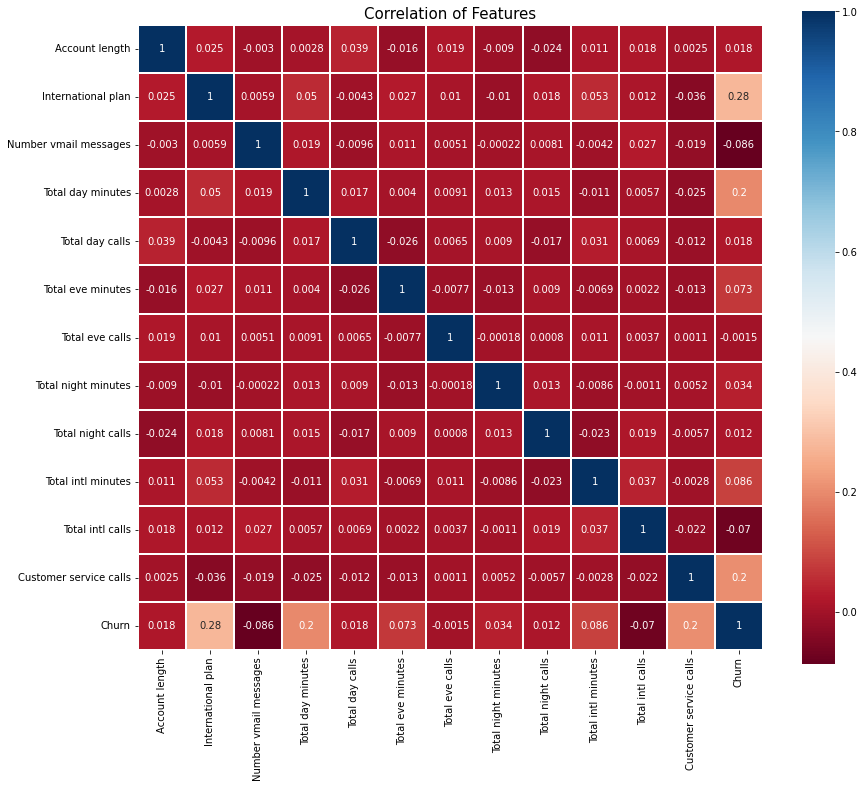

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1, size=15)
sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True, fmt='.2g')
plt.show()

# <text style="color:red; font-size:120%">Ансамбль классификации</text>

Сформируем параллельный ансамбль из моделей LightGBM и Catbost, с заранее выбранными гиперпараметрами.
Итоговое предсказание рассчитаем на основании равноправного голосования.

In [7]:
def func_prep():
    categorical_features = ['International plan']
    numeric_features = X_train.columns.drop(categorical_features)

    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    return preprocessor

def pipe_with_transform(clf, bool_prep=True, bool_select=True, k_feat=13):
    arr = []
    if bool_prep:
        preprocessor = func_prep()
        arr.append(("scl", preprocessor))
    if bool_select:
        selector = SelectKBest(f_classif, k=k_feat)
        arr.append(('feature_selection', selector))
    arr.append(("clf", clf))
    return Pipeline(arr)


# Функция необходима для выбора класса при "мягком" голосования
def vote_class (x):
    a = np.argmax(x.values)
    return a

Поищим лучшие веса для вероятностей

# Подготовка предсказания

In [8]:
X_train = train.drop(columns='Churn')
y_train = train['Churn']
X_test = test

### Модель LightGBM

In [9]:
pipe_lgbm = pipe_with_transform(
    lgb.LGBMRegressor(
        max_depth=5,
        min_child_samples=2
    ), 
    bool_select=False
    )
pipe_lgbm.fit(X_train, y_train)
print()

### Модель Catboost

In [15]:
preprocessor_cb = func_prep()
x_train_transform = preprocessor_cb.fit_transform(X_train)
train_dataset = Pool(data=x_train_transform, label=y_train)

model_catboost = CatBoostClassifier(
        iterations=100,
        learning_rate=0.4,
        depth=4,
        l2_leaf_reg=4,
        loss_function="Logloss",
        bootstrap_type="MVS",
        custom_metric="F1"
        )

model_catboost.fit(train_dataset, verbose=0)
print()

In [12]:
target_test_lgb_proba = 1 - pd.DataFrame(pipe_lgbm.predict(X_test))
target_test_lgb_proba[1] = 1 - target_test_lgb_proba[0]
target_test_cb_proba = pd.DataFrame(
    model_catboost.predict_proba(
        Pool(data=preprocessor_cb.transform(X_test))
        ))

In [13]:
target_test_proba = target_test_lgb_proba
for i in range(0, 2):
    target_test_proba[i] += target_test_cb_proba[i]
target_test_proba["Churn"] = target_test_proba.apply(vote_class, axis=1)

<text style="color:green;font-size: 250%">Итоговое предсказание ID	5769352</text>

In [14]:
target_test_proba["Churn"].astype('bool').to_csv('submit_lgb_cb.csv')